In [1]:
import torch
import os
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
torch.cuda.is_available()

True

In [2]:
ROOT = '/wecare/home/khoi/thesis'
# CT scans and masks in raw nii format
DATA_FOLDER = '/wecare/projects/Slicer_ready_data/Original Patient Data/Normalised_Recsaled_data'
CT_SCANS = os.path.join(DATA_FOLDER,'Images')
MASKS = os.path.join(DATA_FOLDER,'Labels_nii')
# Dataset for the project
AUGMENTED_FOLDER = os.path.join(ROOT, 'ct_processed_aug')
AUGMENTED_SCANS = os.path.join(AUGMENTED_FOLDER, 'images') 
AUGMENTED_MASKS = os.path.join(AUGMENTED_FOLDER, 'masks')
AUGMENTED_LABELS = os.path.join(AUGMENTED_FOLDER, 'labels')
HYPEPARAMETERS = os.path.join(ROOT, 'parameters')

# Explore one CT scan + its mask

## READ MHD and RAW

In [5]:
lnd = 2 # CT scan ID
rad = 1 # Radiologist ID
finding = 1 # Finding ID in this CT scan

# Read scan
[scan, spacing, origin, transfmat] = readMhd(os.path.join(DATA, f'LNDb-{lnd:04}.mhd'))
print(f"scan shape: {scan.shape}")
print(f"scan inf: {spacing, origin, transfmat}")

# Read segmentation mask
[mask, spacing, origin, transfmat] = readMhd(os.path.join(MASK, f'LNDb-{lnd:04}_rad{rad}.mhd'))
print(f"mask shape: {mask.shape}")
print(f"mask inf: {spacing, origin, transfmat}")

# Read nodules csv
csvlines = readCsv(os.path.join(CSV, "trainNodules.csv"))
header = csvlines[0]
nodules = csvlines[1:]

# Extract the world coordinate of the nodule
for n in nodules:
    if int(n[header.index("LNDbID")]) == lnd and int(n[header.index("RadID")]) == rad and int(n[header.index("FindingID")]) == finding:
        ctr = np.array([float(n[header.index("x")]), float(n[header.index("y")]), float(n[header.index("z")])])
        print(f"nodule world coordinate: {ctr}")
        break

scan shape: (263, 512, 512)
scan inf: ((0.724609375, 0.724609375, 1.0), (-174.1376953125, -380.1376953125, -299.5), (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
mask shape: (263, 512, 512)
mask inf: ((0.724609375, 0.724609375, 1.0), (-174.1376953125, -380.1376953125, -299.5), (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
nodule world coordinate: [  88.89550781 -123.62597656 -129.5       ]


In [6]:
unique, counts = np.unique(mask, return_counts=True)
print(np.asarray((unique, counts)).T) # 0 are not nodules, number from 1 - 5 are finding ID

[[       0 68942090]
 [       1      646]
 [       2      311]
 [       3      680]
 [       4      103]
 [       5       42]]


## Convert world coordinates to image coordinates

In [7]:
transfmat_toimg, transfmat_toworld = getImgWorldTransfMats(spacing, transfmat)
ctr = convertToImgCoord(ctr, origin, transfmat_toimg)
print(f"ctr: ctr.x :{ctr[0]}, ctr.y :{ctr[1]}, ctr.z :{ctr[2]}")
print(f"scan shape: {scan.shape}")
print(f"mask shape: {mask.shape}")
print(f"scan[int(ctr[2])] shape: {scan[int(ctr[2])].shape}")

ctr: ctr.x :363.0, ctr.y :354.0, ctr.z :170.0
scan shape: (263, 512, 512)
mask shape: (263, 512, 512)
scan[int(ctr[2])] shape: (512, 512)


## Display nodule scan/mask slice

In [10]:
ctr[2]

170.0

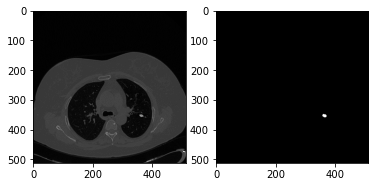

In [8]:
fig, axs = plt.subplots(1,2)
plt.gray()
axs[0].imshow(scan[int(ctr[2])])
axs[1].imshow(mask[int(ctr[2])])
plt.show()

## Extract cube around nodule

In [45]:
scan_cube = extractCube(scan, spacing, ctr)
mask[mask!=finding] = 0
mask[mask>0] = 1
mask_cube = extractCube(mask, spacing, ctr)

In [46]:
print(f"scan_cube shape: {scan_cube.shape}, mask_cube shape: {mask_cube.shape}")

scan_cube shape: (80, 80, 80), mask_cube shape: (80, 80, 80)


## Display mid slices from resampled scan/mask

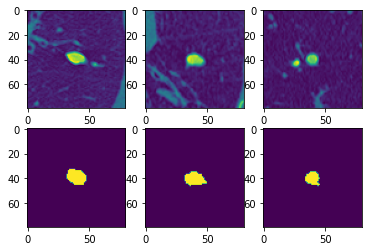

In [38]:
fig, axs = plt.subplots(2,3)
axs[0,0].imshow(scan_cube[int(scan_cube.shape[0]/2),:,:])
axs[1,0].imshow(mask_cube[int(mask_cube.shape[0]/2),:,:])
axs[0,1].imshow(scan_cube[:,int(scan_cube.shape[1]/2),:])
axs[1,1].imshow(mask_cube[:,int(mask_cube.shape[1]/2),:])
axs[0,2].imshow(scan_cube[:,:,int(scan_cube.shape[2]/2)])
axs[1,2].imshow(mask_cube[:,:,int(mask_cube.shape[2]/2)])
plt.show()

## Convert a scan slice to JPG

In [31]:
scan_slice_prev = scan[int(ctr[2]) - 1]
scan_slice_mid = scan[int(ctr[2])]
scan_slice_after = scan[int(ctr[2]) + 1]
scan_slice = np.dstack((scan_slice_prev, scan_slice_mid, scan_slice_after))
scan_slice.shape

(512, 512, 3)

In [38]:
norm_prev = plt.Normalize(vmin=scan_slice_prev.min(), vmax=scan_slice_prev.max())
norm_after = plt.Normalize(vmin=scan_slice_after.min(), vmax=scan_slice_after.max())
scan_slice_prev_rescaled = norm_prev(scan_slice_prev)
scan_slice_after_rescaled = norm_prev(scan_slice_after)

In [32]:
min_val = np.min(scan_slice_mid)
max_val = np.max(scan_slice_mid)
scan_slice_mid_rescaled = (scan_slice_mid - min_val) / (max_val - min_val)
scan_slice_mid_rescaled

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.05274725, 0.04053724, 0.02124542, ..., 0.        , 0.        ,
        0.        ],
       [0.03492063, 0.02246642, 0.01221001, ..., 0.        , 0.        ,
        0.        ],
       [0.01709402, 0.01318681, 0.01343101, ..., 0.        , 0.        ,
        0.        ]])

In [42]:
scan_slice_rescaled = np.dstack((scan_slice_prev_rescaled, scan_slice_mid_rescaled, scan_slice_after_rescaled))

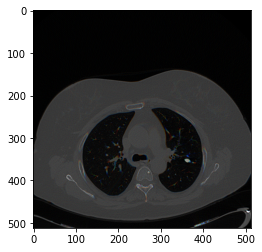

In [44]:
plt.imshow(scan_slice_rescaled)

In [36]:
cmap = plt.gray()
plt.imsave(os.path.join(FOO, "scan-0001.png"), scan_slice_mid_rescaled, cmap = cmap)

<Figure size 432x288 with 0 Axes>

In [43]:
cmap = plt.gray()
plt.imsave(os.path.join(FOO, "scan-0002.png"), scan_slice_rescaled, cmap = cmap)

<Figure size 432x288 with 0 Axes>

# Create bounding box for one CT scan

## Data distribution